# Gradient-free `CRP` parameter optimization

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy.typing import NDArray

import math

from scipy.optimize import minimize

from matplotlib import pyplot as plt

## 1. Set up demo circuit

In [2]:
dev = qml.device("default.qubit", wires=4, shots=None)

num_layers = 5
num_qubits = 4

@qml.qnode(dev)
def an_interesting_circuit(params: NDArray[np.float_]):
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            qml.RX(params[layer, qubit, 0], wires=qubit)
            qml.RZ(params[layer, qubit, 1], wires=qubit)
        for qubit in range(num_qubits - 2, -1, -1): # incl. start, excl. stop, step
            qml.CRZ(params[layer, qubit, 2], (qubit + 1, qubit))
    return qml.expval(qml.PauliZ(1))

print(qml.draw(an_interesting_circuit)(np.random.random((num_layers, num_qubits, 3))))

0: ──RX(0.20)──RZ(0.02)─────────────────────╭RZ(0.19)──RX(0.47)──RZ(0.76)───────────╭RZ(0.81)
1: ──RX(0.04)──RZ(0.24)───────────╭RZ(0.37)─╰●─────────RX(0.26)──RZ(0.76)─╭RZ(0.48)─╰●───────
2: ──RX(0.41)──RZ(0.19)─╭RZ(0.71)─╰●─────────RX(1.00)──RZ(0.13)─╭RZ(0.02)─╰●─────────RX(0.06)
3: ──RX(0.71)──RZ(0.53)─╰●─────────RX(0.60)──RZ(0.10)───────────╰●─────────RX(0.31)──RZ(0.04)

───RX(0.56)──RZ(0.82)───────────╭RZ(0.18)──RX(0.11)──RZ(0.15)───────────╭RZ(0.96)──RX(0.11)
───RX(0.37)──RZ(0.26)─╭RZ(0.18)─╰●─────────RX(0.89)──RZ(0.68)─╭RZ(0.79)─╰●─────────RX(0.24)
───RZ(0.16)─╭RZ(0.37)─╰●─────────RX(0.09)──RZ(0.53)─╭RZ(0.05)─╰●─────────RX(0.40)──RZ(0.18)
────────────╰●─────────RX(0.23)──RZ(0.37)───────────╰●─────────RX(0.85)──RZ(0.03)──────────

───RZ(0.71)───────────╭RZ(0.95)─┤     
───RZ(0.45)─╭RZ(0.69)─╰●────────┤  <Z>
──╭RZ(0.52)─╰●──────────────────┤     
──╰●────────────────────────────┤     


## 2. Optimization loop

In [3]:
def create_univariate(circuit, params: NDArray[np.int_], param_index):
    def univariate(param_value):
        updated_params = params.copy()
        updated_params[param_index] = param_value
        return circuit(updated_params)
    
    return univariate

In [15]:
from reconstruction import reconstruct
from minimization import minimize_reconstruction

# in each iteration, reconstruct and optimize the univariate cost functions independently
def crotosolve_iteration(circuit, params, updates_dataset, debug = False):
    final_value = 42

    iterator = np.nditer(params, flags=['multi_index'])
    for old_param_value in iterator:
        param_index = iterator.multi_index
        if debug: print(f"Optimizing parameter {param_index}...")
        univariate = create_univariate(circuit, params, param_index)
        reconstruction = reconstruct(univariate)
        new_param_value, new_fun_value = minimize_reconstruction(reconstruction)
        if debug: print(f"Parameter update for {param_index} from {old_param_value} to {new_param_value} ({new_fun_value})")
        params[param_index] = new_param_value
        final_value = new_fun_value
        updates_dataset.append(new_fun_value)
    
    return final_value

In [17]:
def crotosolve(circuit, initial_params, debug = False):
    iterations_dataset = []
    updates_dataset = []

    params = initial_params.copy()
    for iteration in range(5):
        if debug: print(f" ===== ITERATION NO {iteration} =====")
        new_fun_value = crotosolve_iteration(circuit, params, updates_dataset, debug=debug)
        iterations_dataset.append(new_fun_value)
    
    return params, iterations_dataset, updates_dataset

rng = np.random.default_rng()
params = rng.random((5, 4, 3))

final_params, iterations_dataset, updates_dataset = crotosolve(an_interesting_circuit, params, debug=True)

 ===== ITERATION NO 0 =====
Optimizing parameter (0, 0, 0)...
Parameter update for (0, 0, 0) from 0.3532093848591785 to 5.953146344609756 (-0.20141665831379502)
Optimizing parameter (0, 0, 1)...
Parameter update for (0, 0, 1) from 0.9407242009981787 to 6.159442192919318 (-0.24926626337241695)
Optimizing parameter (0, 0, 2)...
Parameter update for (0, 0, 2) from 0.417238891732829 to 3.2840784963907845 (-0.6092673462270006)
Optimizing parameter (0, 1, 0)...
Parameter update for (0, 1, 0) from 0.5163713095129882 to 1.3045487941850422 (-0.8571350851073217)
Optimizing parameter (0, 1, 1)...
Parameter update for (0, 1, 1) from 0.9429599267880107 to 0.9339839766752664 (-0.857166606902076)
Optimizing parameter (0, 1, 2)...
Parameter update for (0, 1, 2) from 0.06393854284232403 to 6.350017134998035 (-0.9534853329871428)
Optimizing parameter (0, 2, 0)...
Parameter update for (0, 2, 0) from 0.6777487290292303 to 0.7163534484502174 (-0.9535726708724648)
Optimizing parameter (0, 2, 1)...
Parameter

## 3. Print charts

Text(0.5, 1.0, 'Loss curve over crotosolve iterations')

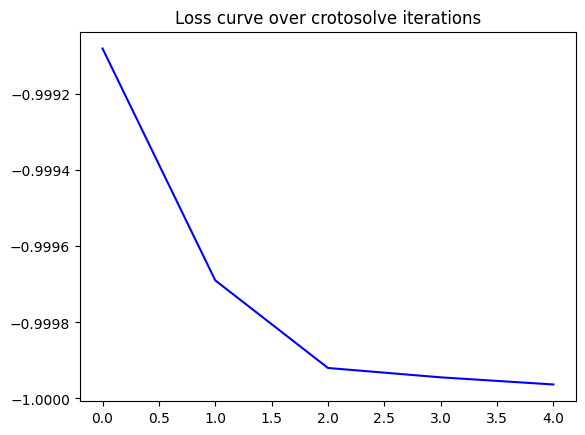

In [18]:

fig, ax = plt.subplots()
ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
ax.set_title("Loss curve over crotosolve iterations")

Text(0.5, 1.0, 'Loss curve over parameter updates')

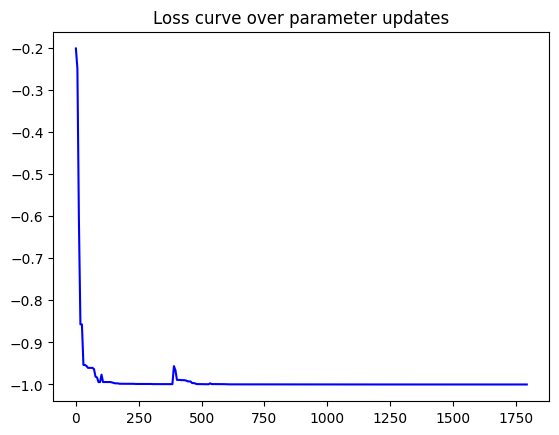

In [19]:

fig, ax = plt.subplots()
# multiply num of updates by 6 to get number of evaluations
ax.plot(6 * np.array(range(len(updates_dataset))), updates_dataset, 'b')
ax.set_title("Loss curve over circuit evaluations")